In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import scipy as sc
import scipy
from scipy import signal
from scipy.stats import kurtosis
import zipfile
from matplotlib import pyplot as plt
from sklearn.preprocessing import RobustScaler
from tensorflow.keras import layers
import pywt


In [ ]:
path = '/content/drive/MyDrive/data/fraunhofer_eas_dataset_for_unbalance_detection_v1.zip'

with zipfile.ZipFile(path, 'r') as f:
    with f.open('0D.csv', 'r') as c:
        data0D = pd.read_csv(c)
    with f.open('0E.csv', 'r') as c:
        data0E = pd.read_csv(c)
    with f.open('1D.csv', 'r') as c:
        data1D = pd.read_csv(c)
    with f.open('1E.csv', 'r') as c:
        data1E = pd.read_csv(c)
    with f.open('2D.csv', 'r') as c:
        data2D = pd.read_csv(c)
    with f.open('2E.csv', 'r') as c:
        data2E = pd.read_csv(c)
    with f.open('3D.csv', 'r') as c:
        data3D = pd.read_csv(c)
    with f.open('3E.csv', 'r') as c:
        data3E = pd.read_csv(c)
    with f.open('4D.csv', 'r') as c:
        data4D = pd.read_csv(c)
    with f.open('4E.csv', 'r') as c:
        data4E = pd.read_csv(c)

Beacause the problem of Ram memory, the demo code just learn the data from sensor 'vibration 1'

In [ ]:
#From the dataset, Since the tutorial said that the first about 10 seconds are noisy due to the warm-up phase of the measuring device, the first 50000 samples are skipped.
skip = 50000
end_skip = 6843567 
# (“data0” = no unbalance, ... “data4” = strong unbalance), 
#  dataset (“D” = development or training, “E” = evaluation)

data0D = data0D.iloc[skip:,:]['Vibration_1'].values
data1D = data1D.iloc[skip:,:]['Vibration_1'].values
data2D = data2D.iloc[skip:,:]['Vibration_1'].values
data3D = data3D.iloc[skip:,:]['Vibration_1'].values
data4D = data4D.iloc[skip:,:]['Vibration_1'].values

data0E = data0E.iloc[skip:,:]['Vibration_1'].values
data1E = data1E.iloc[skip:,:]['Vibration_1'].values
data2E = data2E.iloc[skip:,:]['Vibration_1'].values
data3E = data3E.iloc[skip:,:]['Vibration_1'].values
data4E = data4E.iloc[skip:,:]['Vibration_1'].values

In [ ]:
data0E

array([0.02036691, 0.0191915 , 0.01686096, ..., 0.00062585, 0.00130892,
       0.001055  ])

In [ ]:
# Function for increasing effect of extracting
def conjugate(X):
    (f,X)= signal.welch(X, fs=4096, nperseg=4096)
    X = X*np.conj(X)
    return X
def semilog(X):
    (f,X)= signal.welch(X, fs=4096, nperseg=4096)
    X = np.log10(X)
    return X

# Extracting Fuction


# shannon entropy (cut signals to 500 bins)
def calculate_entropy(arr):
    ent = []
    n = len(arr)
    # print(arr.shape)
    # print(n)
    for i in range(n):
        ent_element = []
        for j in range(np.int(4096//500)):
            # print(j)
            unique, counts = np.unique(arr[i,(j*500):((j+1)*500)], return_counts=True)
            ent_element.append(scipy.stats.entropy(counts,axis = -1))
        ent.append(ent_element)
    return np.array(ent).reshape(n,8)

def calculate_rms(arr):
    m,n = arr.shape
    result = np.sqrt(np.sum(arr**2,axis=-1))/4096
    return result.reshape(m,1)

def calculate_statistics(arr):
    m,n = arr.shape
    n5 = np.nanpercentile(arr, 5, axis = 1).reshape(m,1)
    n25 = np.nanpercentile(arr, 25, axis = 1).reshape(m,1)
    n75 = np.nanpercentile(arr, 75,axis = 1).reshape(m,1)
    n95 = np.nanpercentile(arr, 95,axis = 1).reshape(m,1)
    median = np.nanpercentile(arr, 50,axis = 1).reshape(m,1)
    mean = np.nanmean(arr,axis = 1).reshape(m,1)
    std = np.nanstd(arr,axis = 1).reshape(m,1)
    var = np.nanvar(arr,axis = 1).reshape(m,1)
    rms = np.nanmean(np.sqrt(arr**2),axis = 1).reshape(m,1)
    return np.hstack([n5, n25, n75, n95, median, mean, std, var, rms])


def featureExtraction(X):
    n,_ = X.shape
    statistics_value = calculate_statistics(X) #(n,9)
    rms_value = calculate_rms(X) #(n,1)
    kurtosis_value = scipy.stats.kurtosis(X,axis =-1).reshape(n,1)
    skewness_value = scipy.stats.skew(X,axis = -1).reshape(n,1)
    featureExtracted = np.hstack([statistics_value,kurtosis_value,skewness_value,rms_value]) #(n,20)
    return featureExtracted

In [ ]:
labels = {'no_unbalance':0, 'unbalance':1}


window = 4096
def split_window(arr,nperseg): # overlap = nperseg//2
    length = len(arr)
    n = int(np.floor(length/nperseg))
    arr = arr[:n*nperseg]
    brr  = arr.copy()
    brr[:-int(nperseg/2)]= arr[int(nperseg/2):]
    arr = arr.reshape(n,nperseg)
    brr = brr.reshape(n,nperseg)
    c =np.hstack([arr,brr])
    c=c.reshape(2*n,nperseg)
    return c[:-1]
def simple_split(arr,nperseg):
    length = len(arr)
    n = int(np.floor(length/nperseg))
    arr = arr[:n*nperseg]
    arr = arr.reshape(n,nperseg)
    return arr
def rescale (X):
    max = np.max(X,axis=-1)
    for i in range(len(X)):
        X[i] = X[i]/max[i]
    return X
def get_features(data, label):# Also have rescale function 
    length = len(data)
    n = int(np.floor(length/window))
    # Wavelet descompostion
    X = split_window(data,window) # (n,window/2)
    # X_ent = rescale(calculate_entropy(X))# (n,8)
    
    # print('X:',X.shape)
    A,D3,D2,D1 = pywt.wavedec(X, wavelet= 'db4', level=3)

    # FFT 
    (f,X_A ) = signal.welch(A, fs=4096)
    (f,X_D1 ) = signal.welch(D1, fs=4096)
    (f,X_D2)  = signal.welch(D2, fs=4096)
    (f,X_D3)  = signal.welch(D3, fs=4096)

    X_A = rescale(X_A)
    X_D1 = rescale(X_D1)
    X_D2 = rescale(X_D2)
    X_D3 = rescale(X_D3)

    
    X = np.hstack([X_A,X_D1,X_D2,X_D3])
    y = np.ones(len(X))*labels[label]

    return X,y
X0,y0 = get_features(data0D, "no_unbalance")
X1,y1 = get_features(data1D, "unbalance")
X2,y2 = get_features(data2D, "unbalance")
X3,y3 = get_features(data3D, "unbalance")
X4,y4 = get_features(data4D, "unbalance")
X=np.concatenate([X0, X1, X2, X3, X4])
y=np.concatenate([y0, y1, y2, y3, y4])

X0_val, y0_val = get_features(data0E, "no_unbalance")
X1_val, y1_val = get_features(data1E, "unbalance")
X2_val, y2_val = get_features(data2E, "unbalance")
X3_val, y3_val = get_features(data3E, "unbalance")
X4_val, y4_val = get_features(data4E, "unbalance")
X_val=np.concatenate([X0_val, X1_val, X2_val, X3_val, X4_val])
y_val=np.concatenate([y0_val, y1_val, y2_val, y3_val, y4_val])

In [ ]:

print(X0_val.shape,'-',y0_val.shape)
print(X1_val.shape,'-',y1_val.shape)
print(X2_val.shape,'-',y2_val.shape)
print(X3_val.shape,'-',y3_val.shape)
print(X4_val.shape,'-',y4_val.shape)

(3339, 516) - (3339,)
(3345, 516) - (3345,)
(3337, 516) - (3337,)
(3343, 516) - (3343,)
(3349, 516) - (3349,)


In [ ]:
X_val.shape

(16713, 431)

In [ ]:
# # scaling
# scaler = RobustScaler(quantile_range=(5,95)).fit(X)
# X = scaler.transform(X)
# X_val = scaler.transform(X_val)
# # X = tf.constant(X)
# # y = tf.constant(y)
# # X_val = tf.constant(X_val)
# # y_val = tf.constant(y_val)

<ipython-input-6-f315dce56f43>:22: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  for j in range(np.int(4096//500)):


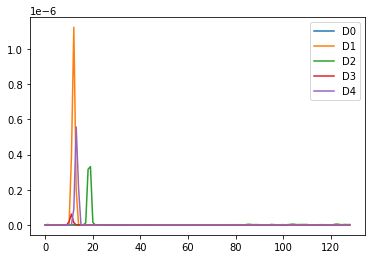

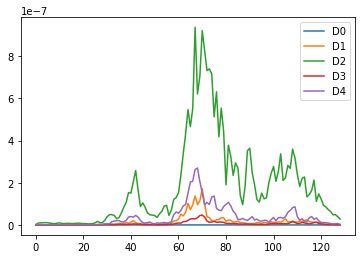

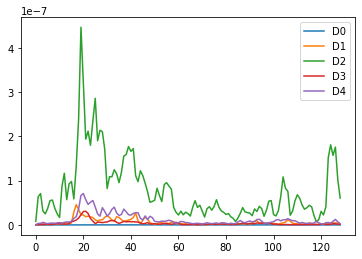

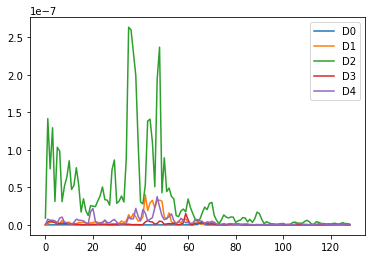

In [ ]:
indx = 10
X_test = split_window(data0D,window) # (n,window/2)
X_ent = calculate_entropy(X_test)# (n,8)

# print('X:',X.shape)
A,D3,D2,D1 = pywt.wavedec(X_test, wavelet= 'db4', level=3)

(f,X_A ) = signal.welch(A, fs=4096)
(f,X_D1)  = signal.welch(D1, fs=4096)
(f,X_D2)  = signal.welch(D2, fs=4096)
(f,X_D3)  = signal.welch(D3, fs=4096)

# plt.plot(A[indx],label ='A')
plt.plot(X_A[indx], label ='D0')
plt.plot(X_A[indx+3000], label ='D1')
plt.plot(X_A[indx+6000], label ='D2')
plt.plot(X_A[indx+9000], label ='D3')
plt.plot(X_A[indx+10000], label ='D4')
plt.legend()
plt.show()

plt.plot(X_D1[indx], label ='D0')
plt.plot(X_D1[indx+3000], label ='D1')
plt.plot(X_D1[indx+6000], label ='D2')
plt.plot(X_D1[indx+9000], label ='D3')
plt.plot(X_D1[indx+10000], label ='D4')
plt.legend()
plt.show()
plt.plot(X_D2[indx], label ='D0')
plt.plot(X_D2[indx+3000], label ='D1')
plt.plot(X_D2[indx+6000], label ='D2')
plt.plot(X_D2[indx+9000], label ='D3')
plt.plot(X_D2[indx+10000], label ='D4')
plt.legend()
plt.show()
plt.plot(X_D3[indx], label ='D0')
plt.plot(X_D3[indx+3000], label ='D1')
plt.plot(X_D3[indx+6000], label ='D2')
plt.plot(X_D3[indx+9000], label ='D3')
plt.plot(X_D3[indx+10000], label ='D4')
plt.legend()
plt.show()


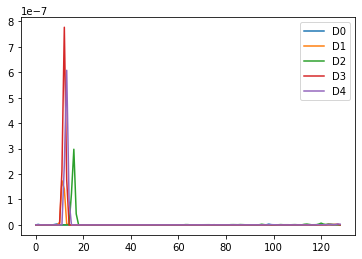

<ipython-input-6-f315dce56f43>:22: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  for j in range(np.int(4096//500)):


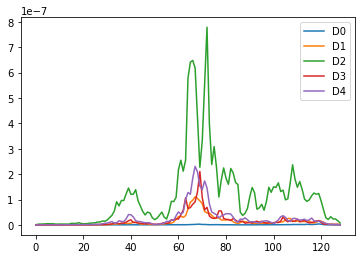

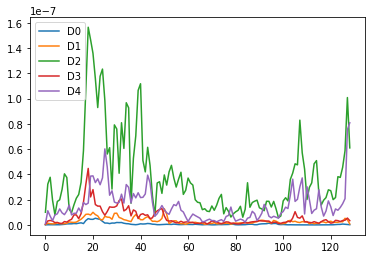

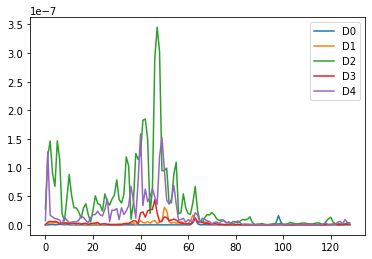

In [ ]:
indx = 10
X_test = split_window(data0E,window) # (n,window/2)
X_ent = calculate_entropy(X_test)# (n,8)

# print('X:',X.shape)
A,D3,D2,D1 = pywt.wavedec(X_test, wavelet= 'db4', level=3)

(f,X_A ) = signal.welch(A, fs=4096)
(f,X_D1)  = signal.welch(D1, fs=4096)
(f,X_D2)  = signal.welch(D2, fs=4096)
(f,X_D3)  = signal.welch(D3, fs=4096)

# plt.plot(A[indx],label ='A')
plt.plot(X_A[indx], label ='D0')
plt.plot(X_A[indx+600], label ='D1')
plt.plot(X_A[indx+1600], label ='D2')
plt.plot(X_A[indx+2400], label ='D3')
plt.plot(X_A[indx+2600], label ='D4')
plt.legend()
plt.show()

plt.plot(X_D1[indx], label ='D0')
plt.plot(X_D1[indx+600], label ='D1')
plt.plot(X_D1[indx+1600], label ='D2')
plt.plot(X_D1[indx+2400], label ='D3')
plt.plot(X_D1[indx+2600], label ='D4')
plt.legend()
plt.show()
plt.plot(X_D2[indx], label ='D0')
plt.plot(X_D2[indx+600], label ='D1')
plt.plot(X_D2[indx+1600], label ='D2')
plt.plot(X_D2[indx+2400], label ='D3')
plt.plot(X_D2[indx+2900], label ='D4')
plt.legend()
plt.show()
plt.plot(X_D3[indx], label ='D0')
plt.plot(X_D3[indx+600], label ='D1')
plt.plot(X_D3[indx+1600], label ='D2')
plt.plot(X_D3[indx+2400], label ='D3')
plt.plot(X_D3[indx+2900], label ='D4')
plt.legend()
plt.show()


In [ ]:
a

In [ ]:
X_A_scaled= semilog(X_A)
X_D3_scaled = semilog(X_D3)
X_D2_scaled = semilog(X_D2)
print(X_D3_scaled)

[[-10.76465825 -10.23121774 -10.11145597 ...  -9.8177141   -9.82410535
  -11.26170438]
 [-10.80992792 -10.24410922  -9.96481453 ...  -9.82822073  -9.98467617
  -12.32614894]
 [-11.56749629 -10.22677793  -9.85202894 ... -10.42841944 -10.17997528
  -10.8336031 ]
 ...
 [-10.75187015  -9.60469905 -10.02797911 ... -10.84264925 -10.9525034
  -11.34674524]
 [-11.1182349  -10.42556696 -10.19760129 ... -10.00181053 -10.76113298
  -11.19093889]
 [-10.80101765 -10.14602817  -9.67886212 ... -10.35494336 -10.67620616
  -11.14069071]]


In [ ]:
 # modeling

weight_for_0 = len(y)/(2*len(y[y==0]))
weight_for_1 = len(y)/(2*len(y[y==1]))
class_weight = {0: weight_for_0, 1: weight_for_1}

# Create model with functional API
inputs = tf.keras.Input(shape=(516,))
x = layers.Dense(units = 1024, activation="linear")(inputs)
x = layers.LeakyReLU(alpha = 0.05)(x)
x = layers.Dense(units = 1024, activation="linear")(x)
x = layers.LeakyReLU(alpha = 0.05)(x)
outputs = layers.Dense(units = 1, activation = 'sigmoid')(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 516)]             0         
                                                                 
 dense_6 (Dense)             (None, 1024)              529408    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 1024)              0         
                                                                 
 dense_7 (Dense)             (None, 1024)              1049600   
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 1024)              0         
                                                                 
 dense_8 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 1,580,033
Trainable params: 1,580,033
Non-tra

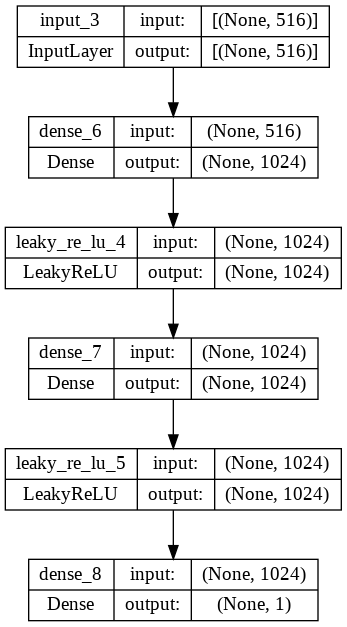

In [ ]:
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
# compile model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=["accuracy"]
)

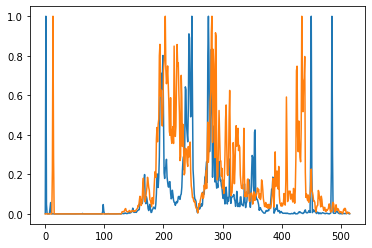

In [ ]:
plt.plot(X_val[0])
plt.plot(X_val[16000])

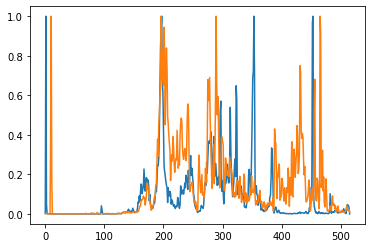

In [ ]:
plt.plot(X[1])
plt.plot(X[60000])

In [ ]:
import os
checkpoint_path="/content/drive/MyDrive/data/training_2/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=504)

model.save_weights(checkpoint_path.format(epoch=0))

In [ ]:
history = model.fit(x=X,y=y,batch_size =128, epochs =100, verbose = 1, validation_data=(X_val,y_val) ,workers = 2, callbacks = [cp_callback],class_weight=class_weight )

Epoch 1/100
503/503 [==============================] - 20s 40ms/step - loss: 0.0111 - accuracy: 0.9959 - val_loss: 0.1107 - val_accuracy: 0.9602
Epoch 2/100

Epoch 2: saving model to /content/drive/MyDrive/data/training_2/cp-0002.ckpt
503/503 [==============================] - 20s 39ms/step - loss: 0.0033 - accuracy: 0.9990 - val_loss: 0.2374 - val_accuracy: 0.9323
Epoch 3/100
  1/503 [..............................] - ETA: 20s - loss: 4.4336e-04 - accuracy: 1.0000
Epoch 3: saving model to /content/drive/MyDrive/data/training_2/cp-0003.ckpt
503/503 [==============================] - 20s 39ms/step - loss: 0.0050 - accuracy: 0.9983 - val_loss: 0.2772 - val_accuracy: 0.9426
Epoch 4/100
  1/503 [..............................] - ETA: 18s - loss: 3.6390e-05 - accuracy: 1.0000
Epoch 4: saving model to /content/drive/MyDrive/data/training_2/cp-0004.ckpt
503/503 [==============================] - 20s 39ms/step - loss: 0.0020 - accuracy: 0.9994 - val_loss: 1.8459 - val_accuracy: 0.7062
Epoch 5/

KeyboardInterrupt: ignored

In [ ]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest


'/content/drive/MyDrive/data/training_2/cp-0006.ckpt'

In [ ]:
model.save('/content/drive/MyDrive/data/DSPfinal.h5')

In [ ]:
model.load_weights('/content/drive/MyDrive/data/training_2/cp-0006.ckpt')

In [ ]:
model.evaluate(x=X_val,y=y_val)

523/523 [==============================] - 3s 6ms/step - loss: 0.6985 - accuracy: 0.9333


[0.6985066533088684, 0.9333453178405762]

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
y_pred = model.predict(X_val)


523/523 [==============================] - 3s 6ms/step


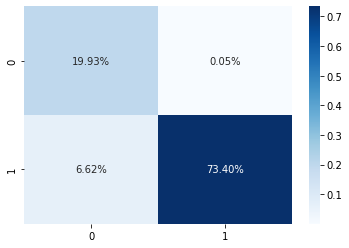

In [ ]:
y_predict = (y_pred>0.5)*1
# print(y)
cf_matrix = confusion_matrix(y_val, y_predict)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,  fmt='.2%', cmap='Blues')